In [2]:
!pip install tensorflow_hub

  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached tf_keras-2.15.0-py3-none-any.whl.metadata (1.6 kB)
Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl (30 kB)
Using cached tf_keras-2.15.0-py3-none-any.whl (1.7 MB)


In [3]:
import warnings
warnings.simplefilter('ignore')
import kserve

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

import numpy as np
import PIL.Image as Image

from kserve import (
    KServeClient,
    utils
)

import os
import tempfile
import boto3

In [5]:
hub_url ="https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-classification/versions/4"

In [6]:
mobilenet_v2 = tf.keras.Sequential([
    hub.KerasLayer(hub_url, output_shape=[1001])
])


Using /tmp/tfhub_modules to cache modules.
Downloaded https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-classification/versions/4, Total size: 14.65MB
Downloaded TF-Hub Module 'https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-classification/versions/4'.
Fingerprint not found. Saved model loading will continue.


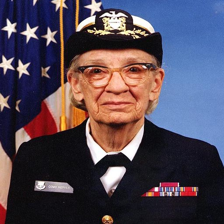

In [7]:
IMAGE_SHAPE = (224, 224)
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [8]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [9]:
result = mobilenet_v2.predict(grace_hopper[np.newaxis, ...].tolist())
result.shape

1/1 [==============================] - 1s 882ms/step


(1, 1001)

In [10]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [11]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

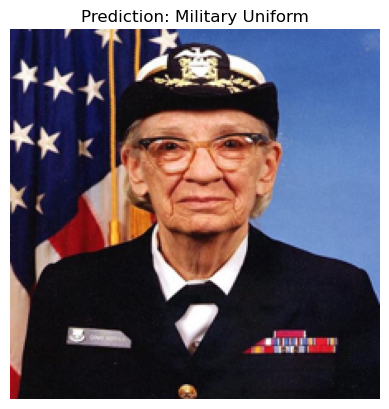

In [12]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [14]:
model_name = "mobilenet_v2"
bucket_name = "kserve-test"
model_path=f"s3://{bucket_name}/models/{model_name}/0001"

In [28]:
aws_access_key_id = "minioadmin"
aws_secret_access_key = "minioadmin"
key_prefix = "mobilenet_v2_model"
minio_endpoint="http://10.85.232.112:9000/"
s3_prefix = "mobilenet_v2_model/0001"

In [29]:
temp_dir = tempfile.mkdtemp()

In [30]:
mobilenet_v2.save(temp_dir)

Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Assets written to: /tmp/tmpb1d7w9er/assets


In [31]:
s3 = boto3.client('s3', endpoint_url=minio_endpoint, aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key)

In [ ]:
for root, dirs, files in os.walk(temp_dir):
    for filename in files:
        local_path = os.path.join(root, filename)
        s3_path = os.path.relpath(local_path, temp_dir)
        s3_key = f"{key_prefix}/{s3_path}"
        s3.upload_file(local_path, bucket_name, s3_key)

In [32]:

for root, dirs, files in os.walk(temp_dir):
    for file in files:
        local_path = os.path.join(root, file)
        relative_path = os.path.relpath(local_path, temp_dir)
        s3_key = os.path.join(s3_prefix, relative_path).replace("\\", "/")  # Replace backslashes with forward slashes

        print(f'Uploading {local_path} to s3://{bucket_name}/{s3_key}')
        s3.upload_file(local_path, bucket_name, s3_key)

Uploading /tmp/tmpb1d7w9er/fingerprint.pb to s3://kserve-test/mobilenet_v2_model/0001/fingerprint.pb
Uploading /tmp/tmpb1d7w9er/saved_model.pb to s3://kserve-test/mobilenet_v2_model/0001/saved_model.pb
Uploading /tmp/tmpb1d7w9er/keras_metadata.pb to s3://kserve-test/mobilenet_v2_model/0001/keras_metadata.pb
Uploading /tmp/tmpb1d7w9er/variables/variables.data-00000-of-00001 to s3://kserve-test/mobilenet_v2_model/0001/variables/variables.data-00000-of-00001
Uploading /tmp/tmpb1d7w9er/variables/variables.index to s3://kserve-test/mobilenet_v2_model/0001/variables/variables.index
